# Studying the correlation between drug-induced transcriptomic response and known targets

Data used (generated in the previous notebook):
- target_vectors.tsv (vectors representing the known targets of each drug)
- transcriptional_response_vectors.tsv (vectors representing the DEG induced by each drug)

In both matrices, the rows are chemicals and the columns are genes. The order of rows/columns is the same in both.

In [1]:
import getpass
import sys
import time
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
from scipy.stats import linregress
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
getpass.getuser()

'chloeengler'

In [3]:
sys.version

'3.9.7 (default, Sep 16 2021, 08:50:36) \n[Clang 10.0.0 ]'

In [4]:
time.asctime()

'Sat Aug  6 10:56:36 2022'

## Load drug-induced transcriptomic response 

In [5]:
transcriptomic_responses_df = pd.read_csv(
    '../data/Transcriptional_data_frames/transcriptional_response_vectors.tsv',
    sep='\t',
    index_col=0,
)
transcriptomic_responses_df.head(4)

,AAAS,AADAC,AADACL2,AADAT,AASS,AATF,ABAT,ABCA1,ABCB1,ABCB11,...,ZSCAN32,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSCAN5DP,ZSCAN9,ZXDA,ZXDB,ZXDC,ZZZ3
CID00001,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,-1,0,0,0,-1
CID00002,0,0,0,0,0,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,-1
CID00006,0,0,0,0,0,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,-1
CID00007,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,-1


## Load the known targets for each drug

In [6]:
targets_df = pd.read_csv(
    '../data/target_data_frames/target_vectors_Chempert.tsv',
    sep='\t',
    index_col=0,
)
# targets_df = targets_df.drop(list(set(targets_df.columns) - set(transcriptomic_responses_df.columns)), axis=1)
# targets_df.to_csv('../data/target_data_frames/target_vectors_Chempert.tsv')
targets_df.head()

,AAAS,AADAC,AADACL2,AADAT,AASS,AATF,ABAT,ABCA1,ABCB1,ABCB11,...,ZSCAN32,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSCAN5DP,ZSCAN9,ZXDA,ZXDB,ZXDC,ZZZ3
CID00001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CID00002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CID00006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CID00007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CID00009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
assert list(targets_df.columns) == list(transcriptomic_responses_df.columns)
assert list(targets_df.index) == list(transcriptomic_responses_df.index)

# Get Chemical Names

In [8]:
#Load chemical names data frame
chemical_names = pd.read_csv('../data/ChemPert_data/Information_for_perturbagens_2.csv', sep='@')
chemical_names = chemical_names.set_index("'id'")
chemical_names.head()

#Create chemical names dictionary
chemical_names_dict_keys = list(chemical_names['Chemical_ID'])
chemical_names_dict_values = list(chemical_names['Chemical_Compound'])
chemical_names_dict = {chemical_names_dict_keys[i]:chemical_names_dict_values[i] for i in \
                       range(len(chemical_names_dict_values))}

In [9]:
import csv

#Get chemical names for chemicals in targets_df
drugs = targets_df.index.values
drug_names = [(chemical_names_dict[drug],drug) for drug in drugs]
drug_names.insert(0,('Chemical Name', 'Chemical ID'))

#Save file of chemical names and IDs
with open('../data/ChemPert_data/chemical_names.csv', 'w') as my_file:
    write = csv.writer(my_file)
    write.writerows(drug_names)

# Calculate Pearson's correlation for each drug

In [10]:
from scipy.stats import pearsonr
from tqdm import tqdm

In [11]:
def get_pearson_corr(
    target_matrix: pd.DataFrame,
    transcriptomic_matrix: pd.DataFrame,
):
    """Get Pearson correlation for each drug."""
    correlation_matrix = []
    
    for drug in tqdm(target_matrix.index.values):
        target_vector = target_matrix.loc[drug, :]
        transcriptomic_vector = transcriptomic_matrix.loc[drug, :]
        corr_val, p_val = pearsonr(target_vector, transcriptomic_vector)
        correlation_matrix.append(
            {
                'drug': drug,
                'pearson_correlation': corr_val
            }
        )
    
    correlation_df = pd.DataFrame(correlation_matrix)
    correlation_df.set_index('drug', inplace=True)
    return correlation_df

In [12]:
pearson_corr_df = get_pearson_corr(target_matrix=targets_df, transcriptomic_matrix=transcriptomic_responses_df)

100%|█████████████████████████████████████| 2152/2152 [00:00<00:00, 2545.30it/s]


In [13]:
pearson_corr_df.describe()

,pearson_correlation
count,2152.000000
mean,0.000399
std,0.011388
min,-0.171500
25%,-0.000394
50%,0.000084
75%,0.000738
max,0.137712


In [14]:
print(pearson_corr_df.loc['CID01388'])
#pearson_corr_df.nlargest(50, 'pearson_correlation')


pearson_correlation    0.007403
Name: CID01388, dtype: float64


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

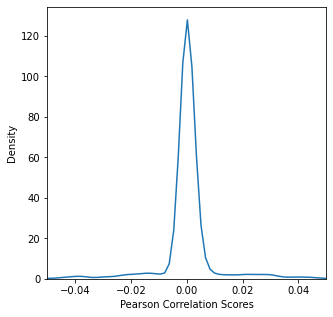

In [16]:
plt.figure(figsize=(5,5))
sns.distplot(pearson_corr_df.values, hist=False)
# Set x-axis label
plt.xlabel('Pearson Correlation Scores')
#plt.savefig('../figures/figure_3a.png')
plt.xlim([-.05,.05])
plt.show()

### Pearson Correlation for Drugs with More Than 10 Targets

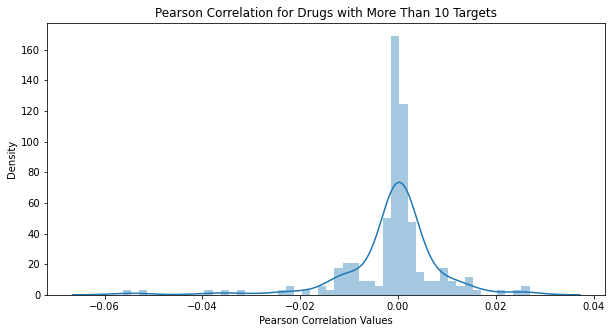

P-value: 5.985235156602542e-06
Mean Pearson Correlation for Drugs with More Than 10 Targets: -0.0011089977739461873
Mean Pearson Correlation for All Drugs: 0.0003991182731171203


In [17]:
# Check out the drugs with more than 10 targets and see if they have a higher corrrelation than the rest

#Set initial variables
corr_many_targets = []

#Get drugs with more than 10 targets
for drug in targets_df.index.values:
    if np.count_nonzero(targets_df.loc[drug]) > 10:
        corr_many_targets.append(pearson_corr_df.loc[drug, 'pearson_correlation'])


plt.figure(figsize=(10,5))
sns.distplot(corr_many_targets)
plt.title("Pearson Correlation for Drugs with More Than 10 Targets")
plt.xlabel('Pearson Correlation Values')
plt.show()

#Print P-value determining whether all drugs and drugs with more than 10 targets
#come from the same distribution
print("P-value: " + str(stats.ks_2samp(corr_many_targets, np.squeeze(pearson_corr_df.values))[1]))
print("Mean Pearson Correlation for Drugs with More Than 10 Targets: " \
      + str(np.nansum(corr_many_targets)/len(corr_many_targets)))
print("Mean Pearson Correlation for All Drugs: " \
      + str(np.nansum(np.squeeze(pearson_corr_df.values))/len(np.squeeze(pearson_corr_df.values))))

### Pearson Correlation for 50 Drugs with the most DEGs

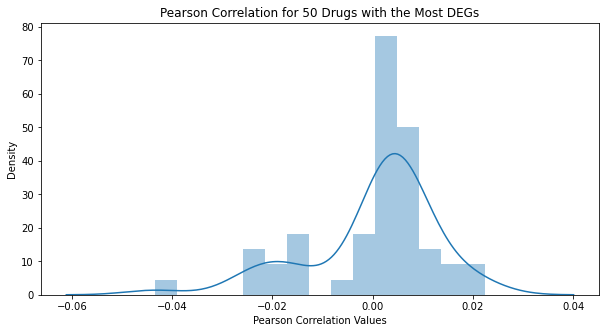

P-value: 1.5010215292932116e-13
Mean Pearson Correlation for 50 Drugs with the Most DEGs: 0.00015772955349779177
Mean Pearson Correlation for All Drugs: 0.0003991182731171203


In [18]:
# Check out the top 50 drugs with more DEG (Differentially expressed genes) and see 
#if they have a higher correlation than the rest

#Set initial variables
num_nonzero_vals = {}

#Get number of DEGs for each drug
for drug in transcriptomic_responses_df.index.values:
    num_nonzero_vals[drug] = np.count_nonzero(transcriptomic_responses_df.loc[drug])
    
#Get 50 drugs with the most DEGs
DEG_drugs = [x for _,x in sorted(zip(num_nonzero_vals.values(), num_nonzero_vals.keys()), reverse=True)]
corr_DEG_drugs = [pearson_corr_df.loc[drug, 'pearson_correlation'] for drug in DEG_drugs[:50]]

plt.figure(figsize=(10,5))
sns.distplot(corr_DEG_drugs)
plt.title("Pearson Correlation for 50 Drugs with the Most DEGs")
plt.xlabel('Pearson Correlation Values')
plt.show()

#Print P-value determining whether all drugs and drugs with more DEGs
#come from the same distribution
print("P-value: " + str(stats.ks_2samp(corr_DEG_drugs, np.squeeze(pearson_corr_df.values))[1]))
print("Mean Pearson Correlation for 50 Drugs with the Most DEGs: " \
      + str(np.nansum(corr_DEG_drugs)/len(corr_DEG_drugs)))
print("Mean Pearson Correlation for All Drugs: " \
      + str(np.nansum(np.squeeze(pearson_corr_df.values))/len(np.squeeze(pearson_corr_df.values))))

# Calculate Jaccard's similarity for each drug

In [19]:
from scipy.spatial.distance import jaccard

In [20]:
def get_jaccard_correlation(
    target_matrix: pd.DataFrame,
    transcriptomic_matrix: pd.DataFrame,
):
    """Get Jaccard similarity for each drug."""
    correlation_matrix = []
    
    for drug in tqdm(target_matrix.index.values):
        target_vector = target_matrix.loc[drug, :]
        transcriptomic_vector = transcriptomic_matrix.loc[drug, :]
        dissimilarity_score = jaccard(target_vector, transcriptomic_vector)
        similarity = 1 - dissimilarity_score
        correlation_matrix.append(
            {
                'drug': drug,
                'jaccard_correlation': similarity
            }
        )
    
    correlation_df = pd.DataFrame(correlation_matrix)
    correlation_df.set_index('drug', inplace=True)
    return correlation_df

In [21]:
jaccard_corr_df = get_jaccard_correlation(
    target_matrix=targets_df, 
    transcriptomic_matrix=transcriptomic_responses_df
)

100%|█████████████████████████████████████| 2152/2152 [00:00<00:00, 5107.03it/s]


In [22]:
jaccard_corr_df.describe()

,jaccard_correlation
count,2152.000000
mean,0.000197
std,0.000837
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,0.018868


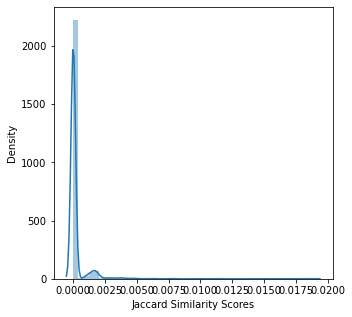

In [23]:
plt.figure(figsize=(5,5))
sns.distplot(jaccard_corr_df.values)
# Set x-axis label
plt.xlabel('Jaccard Similarity Scores')
#plt.savefig('../figures/figure_3c.png')
plt.show()

# Compare between correlation metrics

In [24]:
all_corr_df = pd.merge(pearson_corr_df, jaccard_corr_df, on='drug', how='inner')
all_corr_df.head()

,pearson_correlation,jaccard_correlation
drug,,
CID00001,0.016562,0.001605
CID00002,-0.001125,0.000000
CID00006,0.001420,0.000000
CID00007,0.000419,0.000000
CID00009,-0.000900,0.000000


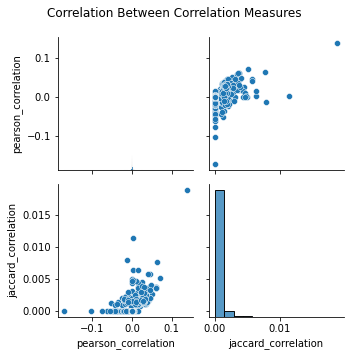

In [25]:

#Make graphs comparing the correltation scores for the different correlation metrics
correlation_types = ['pearson', 'jaccard']
r_values = np.zeros((len(correlation_types), len(correlation_types)))
for i,c1 in enumerate(correlation_types):
    for j,c2 in enumerate(correlation_types):
        slope, intercept, r, p, se = linregress(list(all_corr_df[c1 + '_correlation']), \
                                                list(all_corr_df[c2 + '_correlation']))
        r_values[i,j] = r


sns.pairplot(data=all_corr_df)
plt.suptitle('Correlation Between Correlation Measures')
plt.tight_layout()
plt.show()

# Permutate original targets and original perturbations and re-calculate correlations

### Permutate pairs and apply pearson correlation

In [26]:
def get_pearson_corr_permutation(
    target_matrix: pd.DataFrame,
    transcriptomic_matrix: pd.DataFrame,
):
    """Get Pearson correlation for each drug."""
    correlation_matrix = []
    
    for i,drug in enumerate(target_matrix.index.values):
        target_vector = target_matrix.loc[drug, :]
        transcriptomic_vector = transcriptomic_matrix.iloc[i, :]
        #print(transcriptomic_vector)
        corr_val, p_val = pearsonr(target_vector, transcriptomic_vector)
        correlation_matrix.append(
            {
                'drug': drug,
                'pearson_correlation': corr_val
            }
        )
    
    correlation_df = pd.DataFrame(correlation_matrix)
    correlation_df.set_index('drug', inplace=True)
    return correlation_df

100%|███████████████████████████████████████| 1000/1000 [16:48<00:00,  1.01s/it]


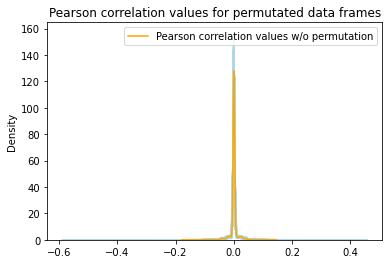

<Figure size 3000x2000 with 0 Axes>

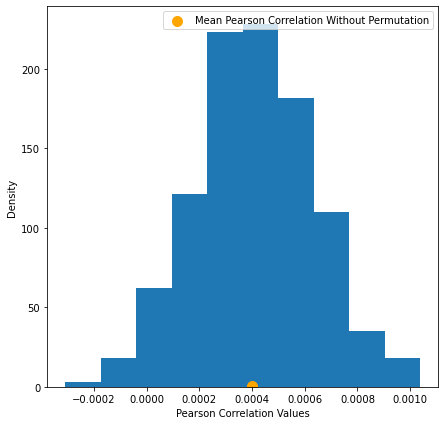

Permutation Test P-Value: 0.503


In [27]:
#Set initial variables
permutation_means = []
num_compounds = targets_df.shape[0]
num_permutations = 1000

#calculate pearson correlation for 100 different permutations
for i in tqdm(range(num_permutations)):
    current_target_df = targets_df.copy()
    current_transcriptomic_df = transcriptomic_responses_df.copy()
    current_transcriptomic_df = current_transcriptomic_df.sample(frac=1)
    current_pearson_corr_df = get_pearson_corr_permutation(target_matrix=current_target_df, \
                                               transcriptomic_matrix=current_transcriptomic_df)
    permutation_means.append(np.nansum(current_pearson_corr_df['pearson_correlation'])/num_compounds)
    sns.distplot(current_pearson_corr_df.values, hist=False, color='lightblue')
    
#Plot pearson correlation scores for the permutations
sns.distplot(pearson_corr_df.values, hist=False, color='orange', label = "Pearson correlation values w/o permutation")
plt.title("Pearson correlation values for permutated data frames")
plt.legend()
plt.show()

#Plot the mean pearson correlation scores for the permutations
plt.figure(dpi=500)
original_mean = np.nansum(pearson_corr_df['pearson_correlation'])/num_compounds
plt.figure().set_size_inches(7,7)
plt.hist(permutation_means, zorder=0)
plt.scatter(original_mean, .2, s = 100, \
            label = 'Mean Pearson Correlation Without Permutation', color = 'orange')
plt.xlabel('Pearson Correlation Values')
plt.ylabel('Density')
plt.legend()
#plt.savefig('../figures/figure_4.png')
plt.show()

#Get the permutation test p-value (based on the means)
p_value = len([x for x in permutation_means if x >= original_mean])/num_permutations
print("Permutation Test P-Value: " + str(p_value))

In [28]:
#Pick random permutation test and do the KS test with the original pearson correlation scores
print("KS test P-value: " + str(stats.ks_2samp(np.squeeze(current_pearson_corr_df.values), 
                                               np.squeeze(pearson_corr_df.values))[1]))

KS test P-value: 0.48327568711273255


### Permutate pairs and apply Jaccard correlation

In [29]:
transcriptomic_responses_df.head()

,AAAS,AADAC,AADACL2,AADAT,AASS,AATF,ABAT,ABCA1,ABCB1,ABCB11,...,ZSCAN32,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSCAN5DP,ZSCAN9,ZXDA,ZXDB,ZXDC,ZZZ3
CID00001,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,-1,0,0,0,-1
CID00002,0,0,0,0,0,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,-1
CID00006,0,0,0,0,0,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,-1
CID00007,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,-1
CID00009,0,0,0,0,0,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,-1


In [30]:
def get_jaccard_corr_permutation(
    target_matrix: pd.DataFrame,
    transcriptomic_matrix: pd.DataFrame,
):
    """Get Jaccard correlation for each drug."""
    correlation_matrix = []
    
    for i,drug in enumerate(target_matrix.index.values):
        target_vector = target_matrix.loc[drug, :]
        transcriptomic_vector = transcriptomic_matrix.iloc[i, :]
        #print(transcriptomic_vector)
        dissimilarity_score = jaccard(target_vector, transcriptomic_vector)
        similarity = 1 - dissimilarity_score
        correlation_matrix.append(
            {
                'drug': drug,
                'jaccard_correlation': similarity
            }
        )
    
    correlation_df = pd.DataFrame(correlation_matrix)
    correlation_df.set_index('drug', inplace=True)
    return correlation_df

100%|███████████████████████████████████████| 1000/1000 [10:29<00:00,  1.59it/s]


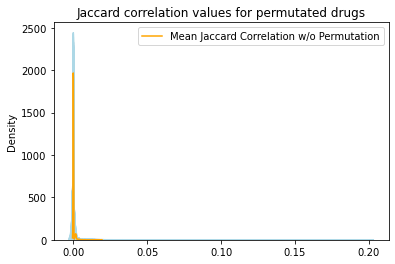

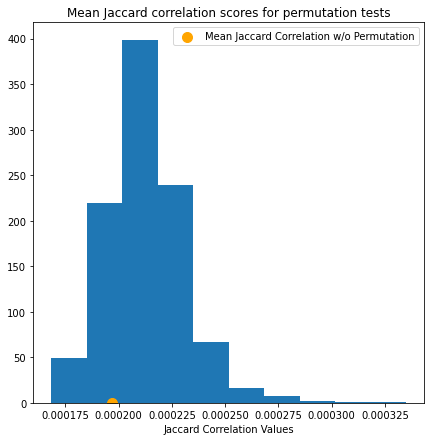

Permutation Test P-Value: 0.813


In [31]:
#Set initial variables
permutation_means = []
num_compounds = targets_df.shape[0]
num_permutations = 1000

#Get jaccard correlation scores for 100 different permutations
for i in tqdm(range(num_permutations)):
    current_target_df = targets_df.copy()
    current_transcriptomic_df = transcriptomic_responses_df.copy()
    current_transcriptomic_df = current_transcriptomic_df.sample(frac=1)
    current_jaccard_corr_df = get_jaccard_corr_permutation(target_matrix=current_target_df, \
                                               transcriptomic_matrix=current_transcriptomic_df)
    permutation_means.append(np.nansum(current_jaccard_corr_df['jaccard_correlation'])/num_compounds)
    sns.distplot(current_jaccard_corr_df.values, hist=False, color='lightblue')
    
#Plot jaccard correlation scores for the permutations
sns.distplot(jaccard_corr_df.values, hist=False, color='orange', label = 'Mean Jaccard Correlation w/o Permutation')
plt.legend()
plt.title("Jaccard correlation values for permutated drugs")
plt.legend()
plt.show()

#Plot the mean jaccard correlation scores for the permutations
original_mean = np.nansum(jaccard_corr_df['jaccard_correlation'])/num_compounds
plt.figure().set_size_inches(7,7)
plt.hist(permutation_means, zorder=0)
plt.scatter(original_mean,.2, s=100,\
            label = 'Mean Jaccard Correlation w/o Permutation', color = 'orange')
plt.xlabel('Jaccard Correlation Values')
plt.title("Mean Jaccard correlation scores for permutation tests")
plt.legend()
plt.show()

#Get the p-value for the permutation test (based on the means)
p_value = len([x for x in permutation_means if x >= original_mean])/num_permutations
print("Permutation Test P-Value: " + str(p_value))

In [32]:
#Pick random permutation test and do the KS test with the original jaccard correlation scores
print("KS test P-value: " + str(stats.ks_2samp(np.squeeze(current_jaccard_corr_df.values), 
                                               np.squeeze(jaccard_corr_df.values))[1]))

KS test P-value: 0.9081931967906852


# Nonzero Values in Target and Transcript Vectors

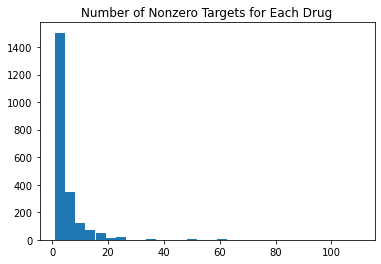

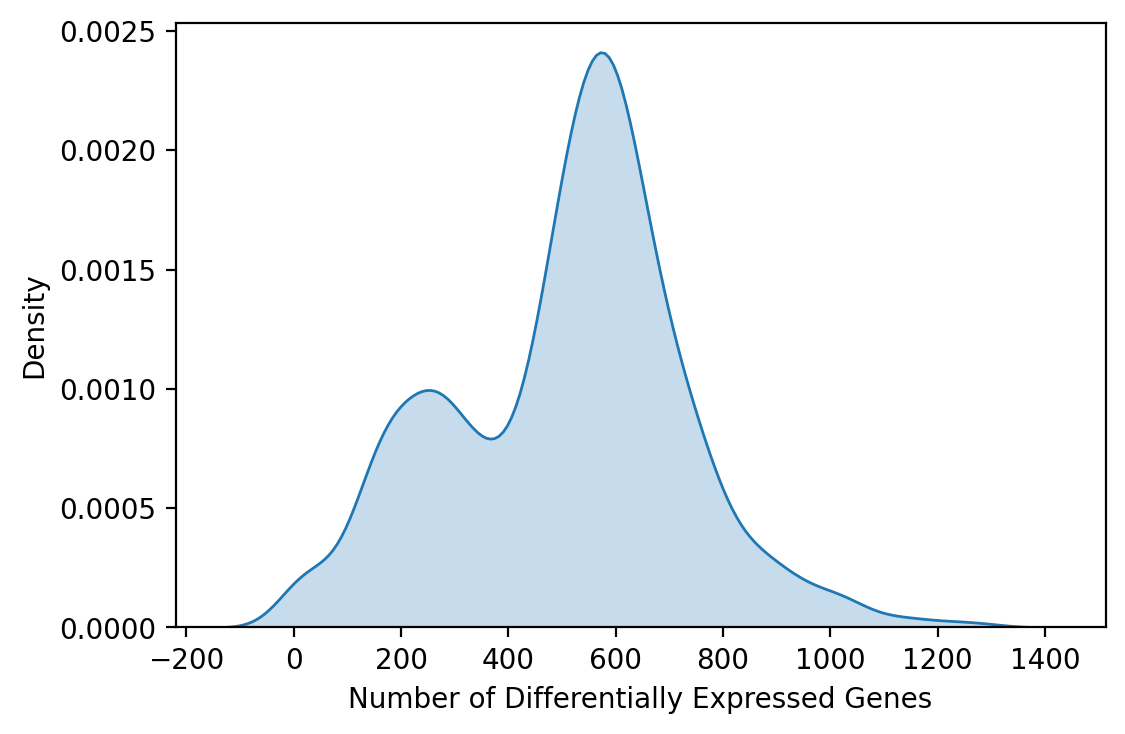

In [33]:
from matplotlib import pyplot as plt
#Set initial variables
num_nonzero_targets = []
num_nonzero_transcript = []

#Get number of nonzero targets and transcripts for each drug
for drug in targets_df.index.values:
    num_nonzero_targets.append(len(np.nonzero(np.array(targets_df.loc[drug, :]))[0]))
    num_nonzero_transcript.append(len(np.nonzero(np.array(transcriptomic_responses_df.loc[drug, :]))[0]))
    
plt.hist(num_nonzero_targets, bins = 30)
plt.title("Number of Nonzero Targets for Each Drug")
plt.show()

plt.figure(dpi=200)
sns.kdeplot(num_nonzero_transcript, shade=True)
#plt.hist(num_nonzero_transcript, bins = 30)
plt.xlabel('Number of Differentially Expressed Genes')
plt.savefig('../figures/supplementary_figure_2.png',bbox_inches='tight')
plt.show()

# Get percentage of the transcriptomic values that match the nonzero target values

In [34]:
#Set initial variables
all_corr_values = []
pearson_corr = []
cosine_corr = []
jaccard_corr = []

#Get percentage of transcriptomic values that match the nonzero target values
for drug in targets_df.index.values:
    num_nonzero_targets = (len(np.nonzero(np.array(targets_df.loc[drug, :]))[0]))
    if num_nonzero_targets != 0:
        
        #Get nonzero target indexes
        old_target_vector = np.array(targets_df.loc[drug, :])
        old_transcriptomic_vector = np.array(transcriptomic_responses_df.loc[drug, :])
        nonzero_indexes = np.nonzero(old_target_vector)[0]
        nonzero_list_1 = [old_target_vector[i] for i in nonzero_indexes]
        nonzero_list_2 = [old_transcriptomic_vector[i] for i in nonzero_indexes]
    
        #Get nonzero target values and corresponding transcriptomic values
        target_vector = np.array(nonzero_list_1)
        transcriptomic_vector = np.array(nonzero_list_2)
        
        #Get percentage of transcriptomic values that match the nonzero target values
        corr_val = np.nansum(abs(np.sign(np.array(target_vector) - np.array(transcriptomic_vector)))-np.ones(len(nonzero_indexes)))\
                    /len(nonzero_indexes)
        all_corr_values.append(abs(corr_val))
        num_nonzero_transcript = (len(np.nonzero(np.array(transcriptomic_responses_df.loc[drug, :]))[0]))
        
        #Get pearson, cosine, and jaccard correlation values for the nonzero target values and corresponding
        #transcriptomic values
        if len(nonzero_list_1) >= 2:
            pearson_corr.append(pearsonr(nonzero_list_1, nonzero_list_2)[0])
        jaccard_corr.append(1 - jaccard(nonzero_list_1, nonzero_list_2))
        

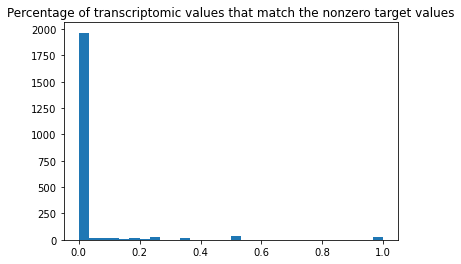

In [35]:
#Plot percentage of transcriptomic values that match the nonzero target values
plt.hist(all_corr_values, bins=30)
plt.title("Percentage of transcriptomic values that match the nonzero target values")
plt.show()

# Clustering Proteins and Drugs

### Get protein Correlation Scores

In [36]:
def get_pearson_corr_proteins(
    target_matrix: pd.DataFrame,
    transcriptomic_matrix: pd.DataFrame,
):
    """Get Pearson correlation for each drug."""
    correlation_matrix = []
    
    for protein in tqdm(target_matrix.columns):
        target_vector = target_matrix[protein]
        transcriptomic_vector = transcriptomic_matrix[protein]
        corr_val, p_val = pearsonr(target_vector, transcriptomic_vector)
        correlation_matrix.append(
            {
                'protein': protein,
                'pearson_correlation': corr_val
            }
        )
    
    correlation_df = pd.DataFrame(correlation_matrix)
    correlation_df.set_index('protein', inplace=True)
    return correlation_df

100%|█████████████████████████████████████| 4938/4938 [00:00<00:00, 8864.79it/s]


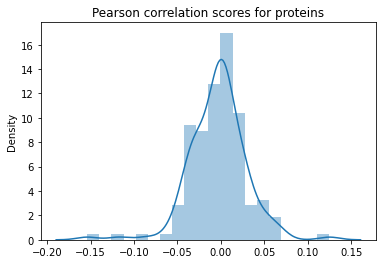

In [37]:
protein_correlation_df = get_pearson_corr_proteins(targets_df, transcriptomic_responses_df)
sns.distplot(protein_correlation_df.values)
protein_correlation_df['protein_uniprot'] = protein_correlation_df.index.values
plt.title('Pearson correlation scores for proteins')
plt.show()

In [38]:
#Get map from HGNC symbols to NCBI genes
map_df= pd.read_csv('../data/Protein_mappings/proteins.tsv', sep='\t', header=None)
map_df = map_df.rename({0: 'NCBI', 2:'HGNC'}, axis=1)
map_df.head()

map_keys = list(map_df['HGNC'])
map_values = list(map_df['NCBI'])
map_dict = {map_keys[i]: map_values[i] for i in range(len(map_keys))}

#Get 1st map to map proteins to NCBI Codes
map_uniprot_df = pd.read_csv('../data/Protein_mappings/proteins_uniprot.tsv', sep='\t', header=None)
map_uniprot_df = map_uniprot_df.rename({0: 'code', 1:'NCBI'}, axis=1)
map_uniprot_df.head()

map_uniprot_keys = list(map_uniprot_df['NCBI'])
print(len(map_uniprot_keys), len(np.unique(map_uniprot_keys)))
map_uniprot_values = list(map_uniprot_df['code'])
map_uniprot_dict = {map_uniprot_keys[i]: map_uniprot_values[i] for i in range(len(map_uniprot_keys))}

#Create function that maps the protein to HGNC symbols
def dict_func(x):
    try:
        result = map_uniprot_dict[map_dict[x]]
    except:
        result = 'None'
    return result

#Convert protein codes to uniprot codes
protein_correlation_df['protein_uniprot'] = protein_correlation_df['protein_uniprot'].map(lambda x: dict_func(x))
protein_correlation_df['protein_uniprot'] = protein_correlation_df['protein_uniprot'].map\
                                            (lambda x: x.split(':')[1] if x != 'None' else x)
print("Number of Unmapped proteins from table 1: " + str(list(protein_correlation_df['protein_uniprot']).count('None')))
print("Number of proteins in table 1: " + str(protein_correlation_df.shape[0]))

180591 102312
Number of Unmapped proteins from table 1: 76
Number of proteins in table 1: 4938


In [39]:
protein_correlation_df.nlargest(20, 'pearson_correlation')

protein_correlation_df.to_csv(r'../data/Protein_mappings/protein_uniprot_codes.csv')

### Plot Protein Class Against Correlation Scores

In [40]:
def get_protein_class(uniprot_code):
    """ Get protein class if the protein is an enzyme.
    If the protein is not an enzyme return 0"""
    try:
        return protein_classes.loc[uniprot_code,'EC number'].split('.')[0]
    except:
        return 0
    
def get_protein_mass(uniprot_code):
    """Get the protein mass"""
    try:
        return float(protein_classes.loc[uniprot_code,'Mass'].replace(',',''))
    except:
        return 0

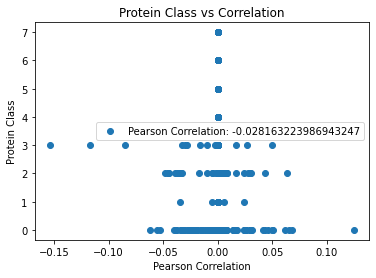

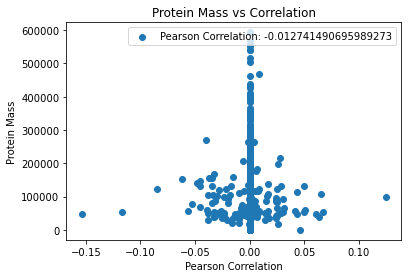

In [41]:
#Set initial variables
protein_classes = pd.read_csv('../data/Protein_classes/protein_classes.csv')
protein_classes = protein_classes.set_index('Entry')

#Add protein mass and class to the data frame
protein_correlation_df['protein_class'] = protein_correlation_df['protein_uniprot']\
                                            .map(lambda x: get_protein_class(x))
protein_correlation_df['mass'] = protein_correlation_df['protein_uniprot']\
                                            .map(lambda x: get_protein_mass(x))
protein_correlation_df['pearson_correlation'] = protein_correlation_df['pearson_correlation']\
                                                .map(lambda x: x if not pd.isna(x) else 0)

#Plot protein class vs. pearson correlation
plt.scatter(protein_correlation_df['pearson_correlation'], protein_correlation_df['protein_class'],\
            label = 'Pearson Correlation: ' + str(pearsonr(protein_correlation_df['pearson_correlation'],\
                                                           protein_correlation_df['protein_class'])[0]))
plt.title("Protein Class vs Correlation")
plt.xlabel('Pearson Correlation')
plt.ylabel('Protein Class')
plt.legend()
plt.show()

#Plot protein mass vs. pearson correlation
plt.scatter(protein_correlation_df['pearson_correlation'], protein_correlation_df['mass'], \
           label = 'Pearson Correlation: ' + str(pearsonr(protein_correlation_df['pearson_correlation'],\
                                                           protein_correlation_df['mass'])[0]))
plt.title("Protein Mass vs Correlation")
plt.xlabel('Pearson Correlation')
plt.ylabel('Protein Mass')
plt.legend()
plt.show()
